In [1]:
import tensorflow as tf

# Lista os dispositivos físicos disponíveis
devices = tf.config.list_physical_devices()
print("Dispositivos físicos:", devices)

# Lista apenas as GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Configura TensorFlow para utilizar a memória da GPU de forma dinâmica
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de crescimento dinâmico da memória GPU aplicada.")
    except Exception as e:
        print("Erro ao configurar GPU:", e)
else:
    print("Nenhuma GPU foi detectada.")


Dispositivos físicos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configuração de crescimento dinâmico da memória GPU aplicada.


Found 22968 images belonging to 2 classes.
Found 5741 images belonging to 2 classes.
Found 7178 images belonging to 2 classes.
Classes: {'boas': 0, 'ruins': 1}


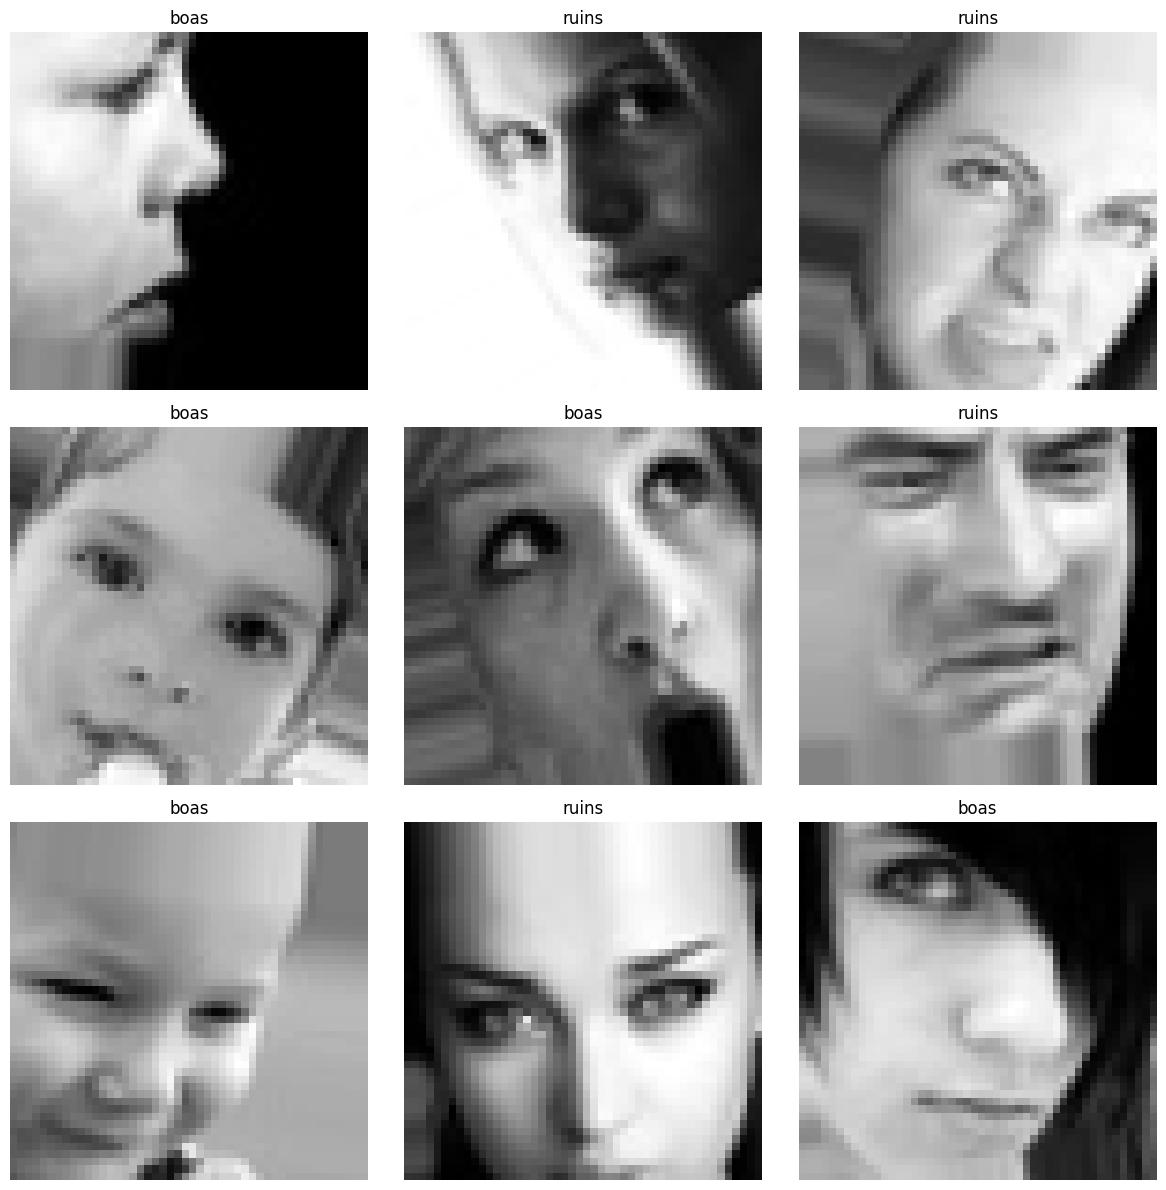

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                        

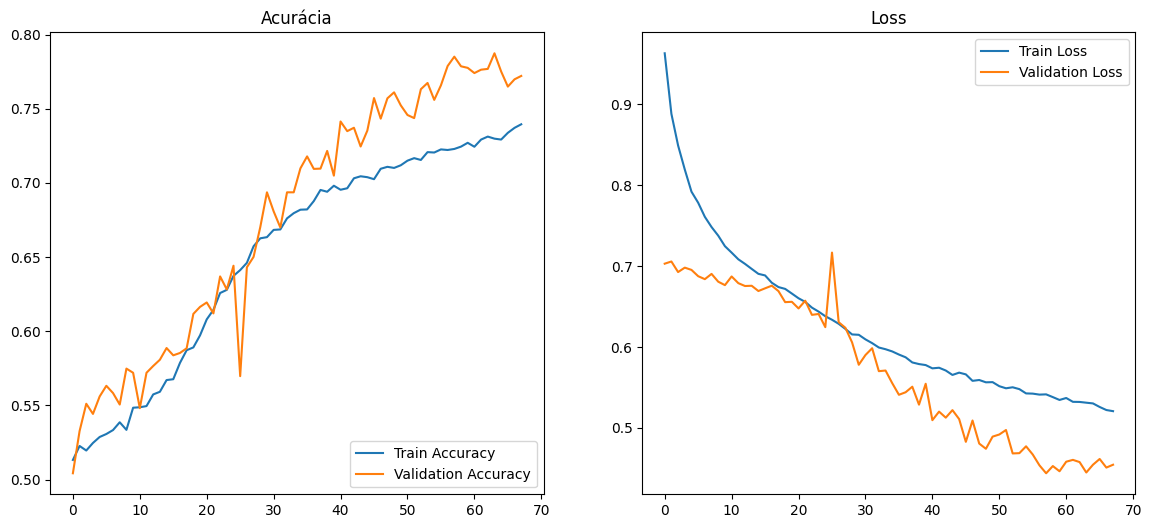

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definindo os caminhos locais para os dados
base_dir = r'C:/Users/LIMCI/Documents/dataset_visao/fer2013'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Se preferir separar um conjunto de validação a partir do treinamento, defina a fração:
validation_split = 0.2

# Configurações
IMG_HEIGHT, IMG_WIDTH = 48, 48   # Dimensões das imagens do FER2013
BATCH_SIZE = 64
EPOCHS = 100

# Pré-processamento e aumento de dados: considerando que as imagens são grayscale.
# Usaremos "color_mode='grayscale'" para carregar somente 1 canal.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split  # 20% para validação
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de dados para treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',   # binário: 'boas' vs 'ruins'
    color_mode='grayscale',
    subset='training',     # Subconjunto de treinamento
    shuffle=True
)

# Gerador de dados para validação
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation',    # Subconjunto para validação
    shuffle=False
)

# Gerador de dados para teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

# Verifica os índices das classes
print("Classes:", train_generator.class_indices)
# Por exemplo, se as pastas estiverem organizadas como "boas" e "ruins",
# o resultado poderá ser: {'boas': 0, 'ruins': 1} ou o inverso.

# Função para visualizar um lote de imagens (para conferir o carregamento e os rótulos)
def visualize_batch(generator, num_images=9):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        # Como as imagens são grayscale, o shape é (48,48,1)
        plt.imshow(images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        label_val = int(labels[i])
        plt.title(class_names[label_val])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualiza um lote do conjunto de treinamento
visualize_batch(train_generator)

# Definindo a arquitetura da CNN, ajustada para imagens em grayscale (1 canal)
model = models.Sequential()

# Primeira camada convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Segunda camada convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Terceira camada convolucional
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Camada densa final
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

# Callbacks: EarlyStopping e ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Treinamento do modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Função para plotar a acurácia e a perda
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Acurácia')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

plot_history(history)

# Salvar o modelo final
model.save('fer2013_cnn_model.h5')
